# Code to get biomarkers and graphics test 

## rutine to read and load the study

In [1]:
from bsp.core import load_study
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [14, 8]


### load a study

In [2]:
study = load_study("data/prueba2.bsp")
print(study[1].angle)

30


In [3]:
for test in study: 
    print(test)

HorizontalCalibration at 30°
HorizontalPursuit at 30°
HorizontalCalibration at 30°


In [13]:
#pursuit = study[1]
#hor_p = pursuit.hor_channel.copy()
#stimuli_p = pursuit.hor_stimuli.copy()
#samples = len(hor_p)
#time = np.arange(samples)/1000.0


#plt.suptitle("señal de salida persecucion suave")

#plt.subplot(111)
#plt.title("señal horizontal")
#plt.plot(time, hor_p)
#plt.plot(time, stimuli_p)

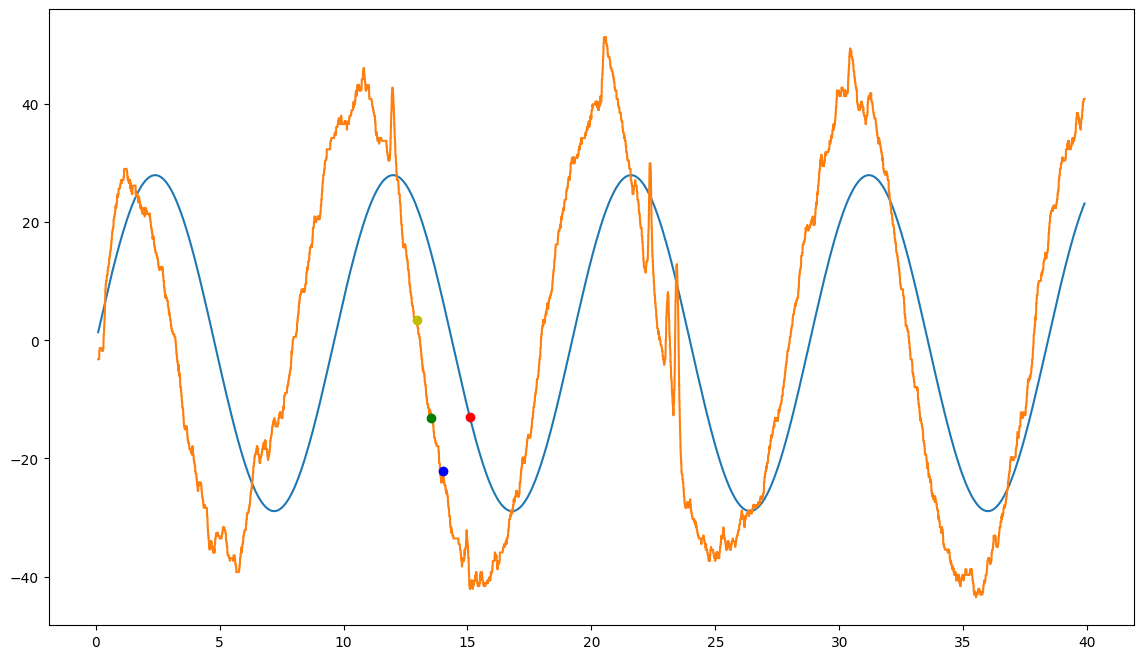

In [4]:
pursuit = study[1]
samples = len(pursuit.hor_channel)
time = np.arange(samples)/1000.0

#plt.suptitle("señal de salida persecucion suave")

#plt.subplot(111)
#plt.title("señal horizontal")
#plt.plot(time, hor_p)
#plt.plot(time, stimuli_p)

remove = 100

hor_p = pursuit.hor_channel.copy()[remove:-remove] *-1
amplitude = hor_p.max()-hor_p.min()
#amplitude

time = time[remove:-remove]

stimuli_p = pursuit.hor_stimuli.copy()[remove:-remove]
stimuli_p -= stimuli_p.mean()
stimuli_p *= (amplitude*2)

plt.plot(time, stimuli_p)
plt.plot(time, hor_p)
#plt.xlim(0, 6)
plt.plot(time[5000], stimuli_p[5000]) #, 'ro', label='punto stimuli')
plt.plot(time[3300], hor_p[3300]) #, 'bo', label='punto horizontal')
#plt.legend()


plt.plot(time[15000], stimuli_p[15000], 'ro', label='punto stimuli')
plt.plot(time[13925], hor_p[13925], 'bo', label='punto horizontal')
plt.plot(time[12850], hor_p[12850], 'yo', label='punto horizontal')
plt.plot(time[13411], hor_p[13411], 'go', label='punto horizontal')

#plt.plot(time[16500], stimuli_p[16500], 'ro', label='punto stimuli')
#plt.plot(time[15000], hor_p[15000], 'bo', label='punto horizontal')

#plt.plot(time[0], stimuli_p[0], 'ro', label='punto stimuli')
#plt.plot(time[0], hor_p[0], 'bo', label='punto horizontal')

In [46]:
print(stimuli_p)
print(hor_p)

[ 1.3766923  1.3947686  1.4135679 ... 23.136238  23.146362  23.156845 ]
[-3.2120361 -3.2120361 -3.2120361 ... 40.85692   40.85692   40.85692  ]


In [15]:
print(hor_p.max())
print(stimuli_p.max())

51.28183
27.948515


897


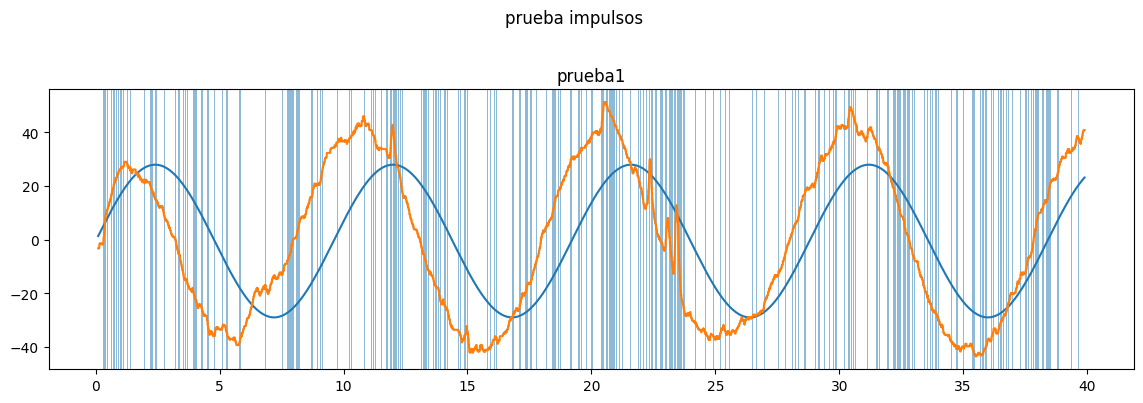

In [5]:
from bsp.core import impulses

plt.suptitle("prueba impulsos")

plt.subplot(211)
plt.title("prueba1")
numImp = 0
for start, end in impulses(hor_p):
    plt.axvspan((start + remove)/1000.0, (end + remove)/1000.0, alpha=0.5)
    numImp +=1

plt.plot(time, stimuli_p)
plt.plot(time, hor_p)

print(numImp)

#plt.xlim(0, 10)

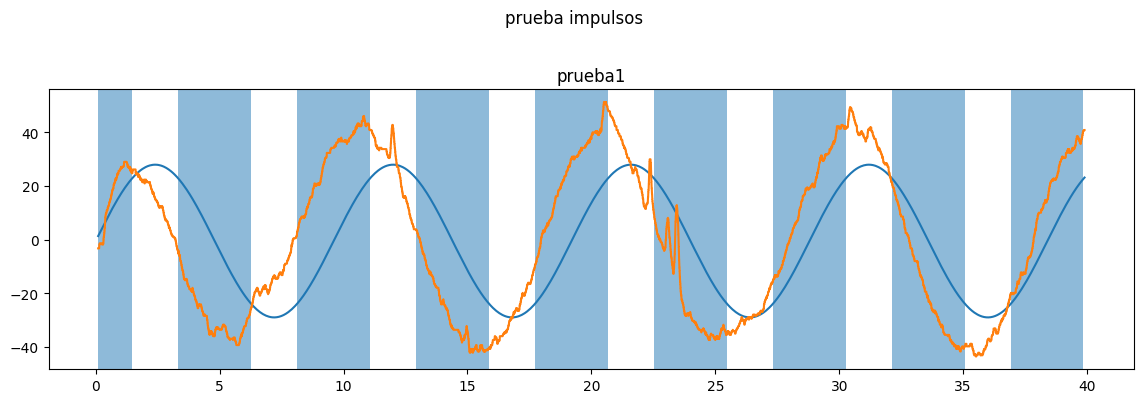

In [6]:
plt.suptitle("prueba impulsos")

plt.subplot(211)
plt.title("prueba1")
numImp = 0
for start, end in impulses(stimuli_p):
    plt.axvspan((start + remove)/1000.0, (end + remove)/1000.0, alpha=0.5)
    numImp +=1

plt.plot(time, stimuli_p)
plt.plot(time, hor_p)

# Error medio cuadratico entre el PMO ajustado en la fase media a la PO
## la idea es restar la punto a punto salida-entrada en el eje x (tiempo)

Si Y es un vector de n predicciones y X es el vector de los verdaderos valores, entonces el (estimado) ECM del predictor es:
$$EMC={1\over n}sum_{i = 1}^{n} \left(Xi-Yi\right)^2$$

displacement=1075
error=120.03237378315939


Text(0, 0.5, 'Ángulo (°)')

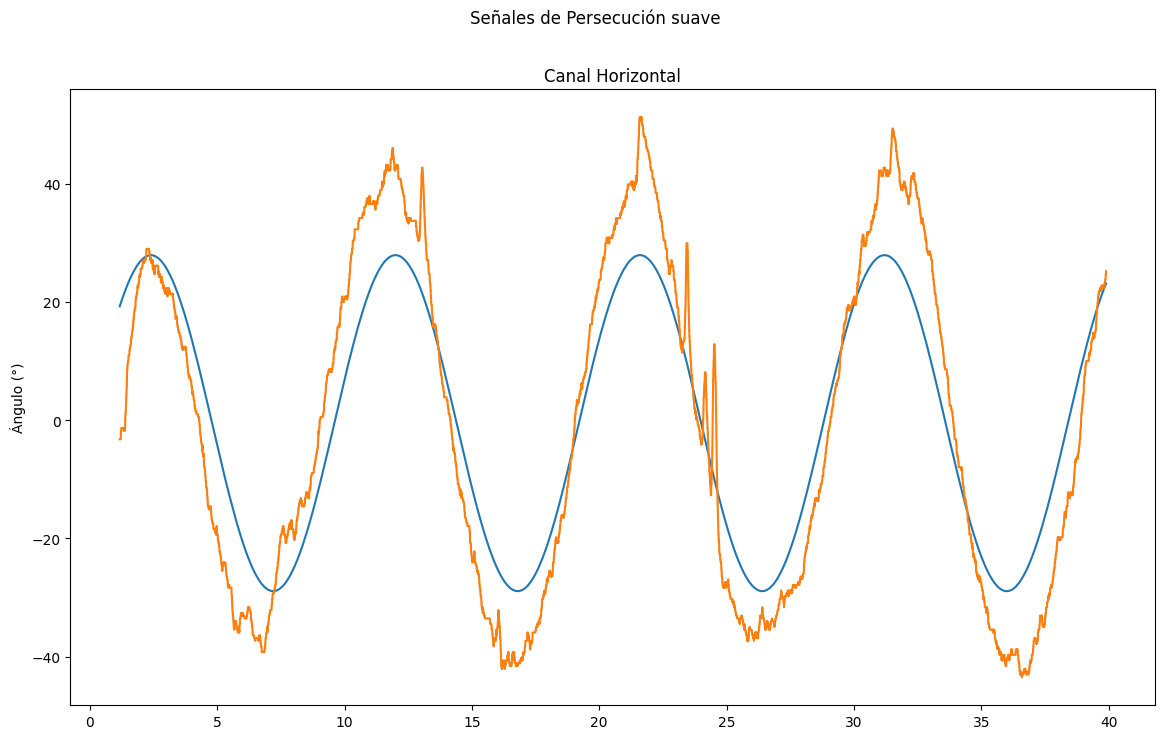

In [16]:
def mse(s1: np.ndarray, s2: np.ndarray) -> float:
    return np.sum((s1 - s2) ** 2) / len(s1)

def move(s: np.ndarray, count: int=1) -> np.ndarray:
    return np.hstack((np.ones(count) * s[0], s[:-count]))
    
    
def best_fit(s1: np.ndarray, s2: np.ndarray) -> tuple[int, float]:
    count = 2000
    errors = np.zeros(count)
    for i in range(1, count + 1):
        offset = move(s2, i)
        errors[i - 1] =  mse(s1, offset)
        best_displacement = errors.argmin()
        best_error = errors[best_displacement]
    return best_displacement, best_error


displacement, error = best_fit(stimuli_p, hor_p)
print(f"{displacement=}")
print(f"{error=}")

offset_hor = move(hor_p,displacement)
plt.suptitle("Señales de Persecución suave")

plt.title("Canal Horizontal")
plt.plot(time[displacement:], stimuli_p[displacement:])
plt.plot(time[displacement:], offset_hor[displacement:])
plt.ylabel("Ángulo (°)")



# Error medio cuadratico de la latencia instantanea

In [5]:
#print(len(hor_p))
#print(hor_p.size)
#el offset es el best_displacement
#para valores ind_stimuli<offset*2 vamos a hacer que el time res = round(ind_stimuli/2)

def min_distance(channel: np.ndarray, stimuli: np.ndarray, ind_stimuli: int, offset: int) -> int:
    time_res = 0
    min_diff = abs(stimuli[ind_stimuli] - channel[ind_stimuli-offset]) 
    for i in range(ind_stimuli-(offset*2),ind_stimuli-offset):
        diff = abs(stimuli[ind_stimuli] - channel[i])
        if diff < min_diff:
            min_diff = diff
            time_res = i
    return time_res 


def real_one(channel: np.ndarray, stimuli: np.ndarray, offset: int) -> float:
    latencies = 0
    mean = 0
    for i in range(offset*2, len(stimuli)):
        latency = min_distance(channel, stimuli, i, offset)
        latencies += (i-latency)
    mean = latencies/(len(stimuli) - (offset*2))
    return mean/1000.0
        

media = real_one(hor_p, stimuli_p, 1075)
print(media)


7.857065179282868


In [6]:
ind_stimuli = 15000
offset = 1075
min_diff = abs(stimuli_p[ind_stimuli]-hor_p[ind_stimuli-offset]) #si ind_stimuli=0 falla
for i in range(ind_stimuli - (offset*2) , ind_stimuli - offset):
    diff = abs(stimuli_p[ind_stimuli] - hor_p[i])
    if diff < min_diff:
        min_diff = diff
        time_res = i

print(min_diff)
print(time_res)



0.09897041
13411


# Número de sácadas correctivas

76


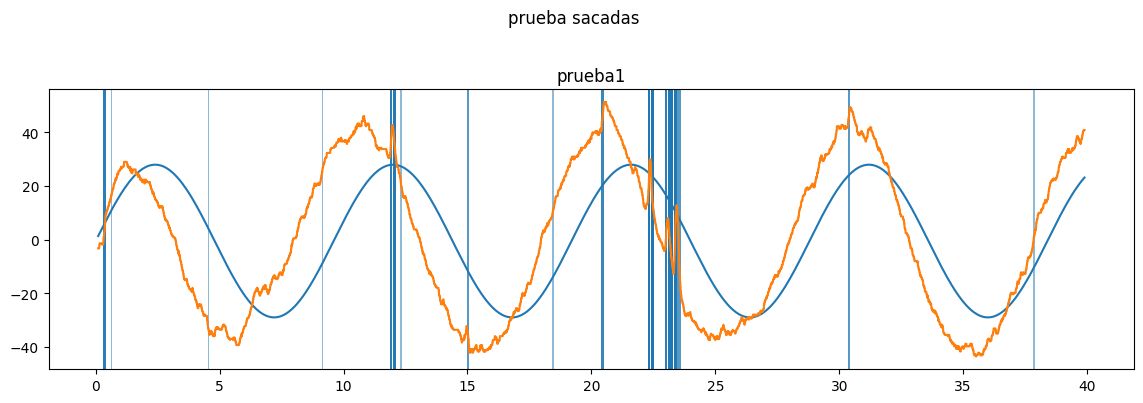

In [8]:
from bsp.core.saccades import saccades 

#listImp = impulses(hor_p)
#listImp
#vamos a probar obtener las sacadas de la señal

plt.suptitle("prueba sacadas")

plt.subplot(211)
plt.title("prueba1")
numSacc = 0
for index in range (study[1].angle+1):
    for start, end in saccades(hor_p, index):
        plt.axvspan((start + remove)/1000.0, (end + remove)/1000.0, alpha=0.5)
        numSacc +=1
    
plt.plot(time, stimuli_p)
plt.plot(time, hor_p)

print(numSacc)
#plt.xlim(21, 24)

# Velocidad media de persecución

18.716729002213793
4657
4666
4687
4696
4708
4717
4736
4745
4752
9438
9445
9471
9472
9473
9480
9501
9503
9524
9532
9533
9541
14276
14277
14278
14285
14299
14308
14320
14328
14329
14337
19055
19064
19083
19084
19085
19092
19106
19115
19143
19150
19151
19159
23844
23851
23852
23860
23888
23889
23890
23897
23911
23920
23939
23948
23955
23962
23969
28627
28634
28641
28648
28667
28675
28676
28683
28695
28696
28697
28704
28718
28726
28727
28735
33437
33444
33470
33471
33472
33479
33500
33502
33523
33531
33532
33540
38258
38267
38286
38287
38288
38295
38307
38308
38309
38316
38337
38346
38353
38374
this is the biomarker number 4 1.0596358716188363
this is the biomarker number 4 with other filter 1.1072589122476864


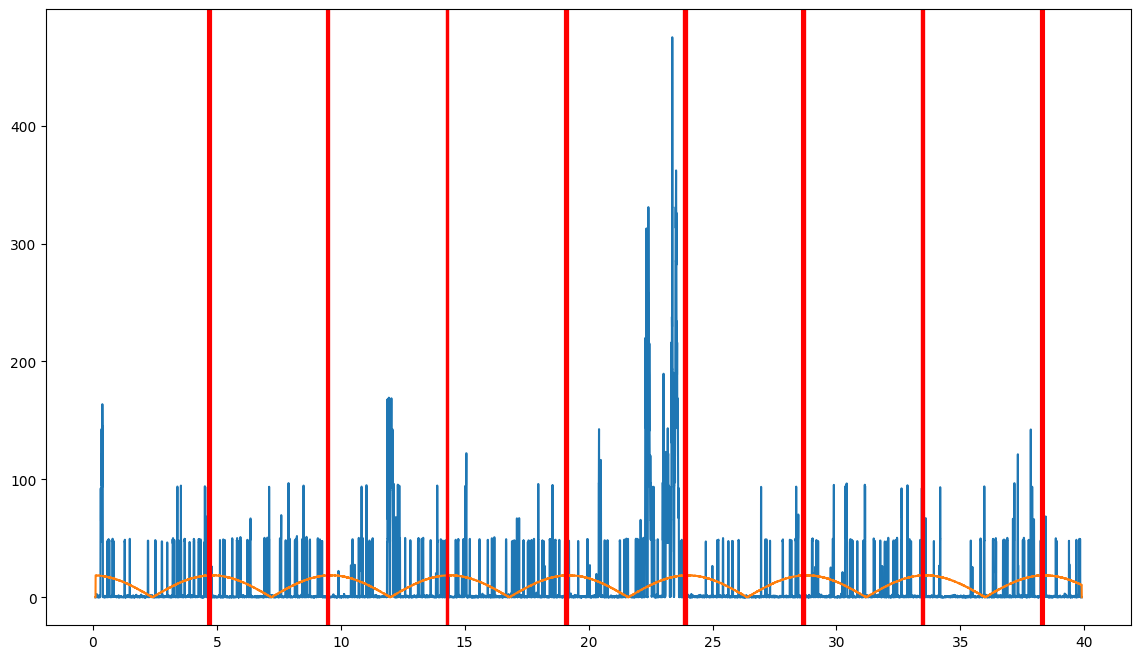

In [24]:
from bsp.core import differentiate, denoise
from scipy.signal import medfilt

noise = np.random.normal(0.05, 0.005, size=len(hor_p))
#hor_filtered = denoise(hor_p)
#hor_f_vel = differentiate(hor_filtered)

hor_filtered_t = hor_p + noise

hor_f_t_vel = differentiate(hor_filtered_t)
mean_pursuit = abs(hor_f_vel.mean())
mean_pursuit1 = abs(hor_f_t_vel.mean())
stimuli_vel = differentiate(stimuli_p)
abs_val = abs(stimuli_vel)
max_vel = max(stimuli_vel)



print(max(stimuli_vel))
#print(type(hor_f_vel))

#plt.subplot(211)
plt.plot(time, abs(medfilt(hor_f_t_vel, 21)))
plt.plot(time, abs(stimuli_vel))
valor = abs(abs(stimuli_vel) - max_vel) < 0.05
current = 0
for i,c in enumerate(valor):
    if c and current<i:
        current = i
        while abs_val[current] < abs_val[current+1]:
            current += 1
        print(current)    
        plt.axvline(current/1000.0,c="red")
#plt.plot(time, hor_filtered_t)



#plt.subplot(212)
#plt.plot(time, hor_f_vel)
#plt.plot(time, hor_f_t_vel)

print("this is the biomarker number 4", mean_pursuit)
print("this is the biomarker number 4 with other filter", mean_pursuit1)

# Ganancia media de la velocidad
## primero vamos a cargar la señal de estimulo y le hacemos la diferenciacion para obtener el perfil de velocidades y hacemos la media.

In [31]:
stimuli_vel = differentiate(stimuli_p)
#plt.plot(time, stimuli_vel)
#plt.plot(time, stimuli_p)

mean_stimuli = abs(stimuli_vel.mean())

print(mean_stimuli)

gain_vel = mean_pursuit/mean_stimuli
gain_vel1 = mean_pursuit1/mean_stimuli

print("this is the biomarker number 5", gain_vel)
print("this is the biomarker number 5 with another filter", gain_vel1)

0.5439768394668067
this is the biomarker number 5 1.9479429908403203
this is the biomarker number 5 with another filter 1.8166218308645559


# Diferencia espectral del PMO y el PO

129
0.9737077


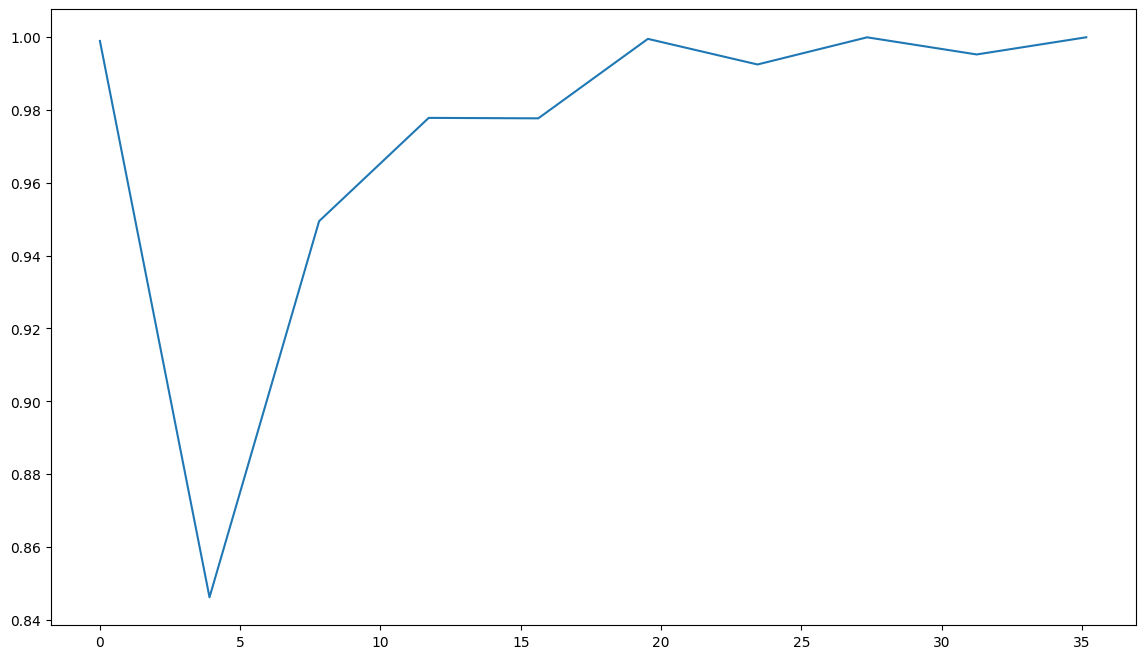

In [44]:
from scipy.fft import fft, fftfreq
from scipy.signal import coherence

def signal_spectrum(s: np.ndarray, fs: float = 1000.0) -> tuple[np.ndarray, np.ndarray]:
    N = len(s)
    T = 1 / fs
    
    x = np.linspace(0.0, N*T, N, endpoint=False)
    yf = fft(s)[:N//2]
    xf = fftfreq(N, T)[:N//2]

    return xf, yf


xs, ys = signal_spectrum(stimuli_p)
xh, yh = signal_spectrum(hor_p)

#
max_s = ys.argmax()
max_h = yh.argmax()
res = yh-ys
res_m = res.argmax()

freq_max_s = xs[max_s]
freq_max_h = xs[max_h]

#plt.plot(xs[:500], res[:500], label='res')
#plt.plot(xs[:500], ys[:500], label='stimuli')
#plt.plot(xh[:30], yh[:30], label='horizontal')
#plt.legend()

#print(max_s, max_h, res_m)
#print(ys.max(), yh.max(), res.max())
#print(ys[max_s], yh[max_h], res[res_m])
#print(freq_max_s)
#print(freq_max_h)

freqs, c = coherence(stimuli_p, hor_p, fs=1000.0)

plt.plot(freqs[:10], (1-c)[:10])

print(len(c))
print((1-c)[:10].mean())

# Final data

In [ ]:
#auxiliar def
def mse(s1: np.ndarray, s2: np.ndarray) -> float:
    return np.sum((s1 - s2) ** 2) / len(s1)

def move(s: np.ndarray, count: int=1) -> np.ndarray:
    return np.hstack((np.ones(count) * s[0], s[:-count]))

def best_fit(s1: np.ndarray, s2: np.ndarray) -> tuple[int, float]:
    count = 2000
    errors = np.zeros(count)
    for i in range(1, count + 1):
        offset = move(s2, i)
        errors[i - 1] =  mse(s1, offset)
        best_displacement = errors.argmin()
        best_error = errors[best_displacement]
    return best_displacement, best_error


# Biomarcador 1
def pursuit_position_mse_biomarker(channel: np.ndarray, stimuli: np.ndarray) -> tuple[int, float]:
    return displacement, error = best_fit(stimuli, channel)

# Biomarcador 2
def pursuit_latency_biomarker(channel: np.ndarray, stimuli: np.ndarray) -> float:
    pass

# Biomarcador 3
def pursuit_microsaccades_count_biomarker(channel: np.ndarray, angle: int = 30) -> int:
    numSacc = 0
    for index in range (angle):
        for start, end in saccades(channel, index):
            numSacc +=1
    return numSacc

# Biomarcador 4
def pursuit_mean_velocity_biomarker(channel: np.ndarray) -> float:
    ch_filtered = medfilt(channel, 201)
    ch_f_vel = differentiate(ch_filtered)
    mean_pursuit = abs(ch_f_vel.mean())
    return mean_pursuit

# Biomarcador 5
def pursuit_mean_velocity_gain_biomarker(channel: np.ndarray, stimuli: np.ndarray) -> float:
    mean_ch = pursuit_mean_velocity_biomarker(channel)
    stimuli_vel = differentiate(stimuli)
    mean_stimuli = abs(stimuli_vel.mean()
    gain_vel = mean_ch/mean_stimuli
    return gain_vel
    
# Biomarcador 6
def pursuit_spectral_difference_biomarker(channel: np.ndarray, stimuli: np.ndarray) -> float:
    freqs, c = coherence(stimuli_p, hor_p, fs=1000.0)
    coherence_factor = ((1-c)[:10].mean())
    return coherence_factor

# DataClass

In [ ]:
from dataclasses import dataclass

@dataclass
class PursuitBiomarkers:
    waveform_mse: float
    mean_latency: float
    corrective_saccades: int
    mean_velocity: float
    gain_velocity: float
    coherence: float

def pursuit_biomarkers(stimuli: ndarray, channel: ndarray) -> PursuitBiomarkers:
    wavefrom_mse = pursuit_position_mse_biomarker(channel, stimuli)[1]
    mean_latency = pursuit_latency_biomarker(channel, stimuli)
    corrective_saccades = pursuit_microsaccades_count_biomarker(channel)
    mean_velocity = ursuit_mean_velocity_biomarker(channel)
    gain_velocity = pursuit_mean_velocity_gain_biomarker(channel, stimuli)
    coherence = pursuit_spectral_difference_biomarker(channel, stimuli)
    return PursuitBiomarkers(waveform_mse, mean_latency, corrective_saccades, mean_velocity, gain_velocity, coherence)

